# PROMPTS EVALUATION FOR QUIZZES

In [41]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [42]:
import re
from collections import Counter
from math import log

def tokenize(text):
    if not isinstance(text, str):
        return []
    return [t for t in re.findall(r"[A-Za-zÀ-ÿ0-9]+", text.lower()) if t]

def jaccard(a_tokens, b_tokens):
    a, b = set(a_tokens), set(b_tokens)
    if not a and not b:
        return 0.0
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union else 0.0

def option_length_variance(options):
    lengths = [len(tokenize(o)) for o in options]
    if not lengths:
        return 0.0
    mu = sum(lengths) / len(lengths)
    return sum((l - mu) ** 2 for l in lengths) / len(lengths)

def tf_cosine(a_text, b_text):
    a_toks = tokenize(a_text)
    b_toks = tokenize(b_text)
    if not a_toks and not b_toks:
        return 0.0
    vocab = list(set(a_toks) | set(b_toks))
    tf_a = {t: 0 for t in vocab}
    tf_b = {t: 0 for t in vocab}
    for t in a_toks:
        tf_a[t] += 1
    for t in b_toks:
        tf_b[t] += 1
    df = {t: (1 if tf_a[t] > 0 else 0) + (1 if tf_b[t] > 0 else 0) for t in vocab}
    idf = {t: log(3 / (df[t] + 1)) + 1.0 for t in vocab}
    va = [tf_a[t] * idf[t] for t in vocab]
    vb = [tf_b[t] * idf[t] for t in vocab]
    dot = sum(x * y for x, y in zip(va, vb))
    na = sum(x * x for x in va) ** 0.5
    nb = sum(y * y for y in vb) ** 0.5
    return dot / (na * nb) if na and nb else 0.0

def avg_pairwise_jaccard(options):
    toks = [tokenize(o) for o in options]
    n = len(toks)
    if n < 2:
        return 0.0
    sims = []
    for i in range(n):
        for j in range(i + 1, n):
            sims.append(jaccard(toks[i], toks[j]))
    return sum(sims) / len(sims) if sims else 0.0

def normalized_entropy(counts, k=4):
    total = sum(counts.values())
    if total == 0:
        return 0.0
    ps = [c / total for c in counts.values()]
    H = -sum(p * log(p + 1e-12) for p in ps)
    Hmax = log(max(k, len(ps)))
    return H / Hmax if Hmax > 0 else 0.0

def has_causal_words(text):
    if not isinstance(text, str):
        return False
    cues = ["because", "therefore", "hence", "thus", "as a result", "due to"]
    tl = text.lower()
    return any(c in tl for c in cues)


## QUIZ QUALITY METRICS - DETAILED EXPLANATION

### **Basic Quality**
- **Success Rate (%)**: Percentage of quizzes generated without errors
  - Calculation: (successful_quizzes / total_quizzes) × 100
  - Higher = better (target: 100%)
  
- **Avg Latency (s)**: Average response time per quiz
  - Calculation: mean of all successful quiz generation times
  - Lower = better (faster generation)

---

### **Option Quality Metrics**

#### **Duplicate Options Rate (%)**
- **What it measures**: Percentage of questions with repeated answer choices
- **Calculation**: Questions with duplicate options / total questions × 100
- **How**: Compares lowercase, trimmed versions of all 4 options
- **Target**: 0% (all options should be unique)
- **Why it matters**: Duplicate options confuse students and indicate poor generation quality

#### **Avg Option Length Variance**
- **What it measures**: Consistency of answer option lengths (in words)
- **Calculation**: Variance of word counts across 4 options per question
- **Formula**: Σ(length - mean_length)² / 4
- **Target**: Lower values = more balanced (prevents "longest answer is correct" pattern)
- **Why it matters**: Students often guess that longer options are correct; balanced lengths reduce this bias

#### **Avg Option Pairwise Jaccard**
- **What it measures**: How similar answer options are to each other (lexical overlap)
- **Calculation**: Average Jaccard similarity between all pairs of options (6 pairs per question)
- **Formula**: Jaccard(A,B) = |A ∩ B| / |A ∪ B| (overlap / union of word sets)
- **Target**: 0.15-0.30 (sweet spot for plausible but distinct options)
- **Why it matters**: 
  - Too low (<0.15): Options are too different, making correct answer obvious
  - Too high (>0.30): Options are too similar, making question confusing or ambiguous
  - Ideal range: Options seem related but are clearly distinguishable

---

### **Semantic Alignment Metrics**

#### **Stem-Option Alignment OK (%)**
- **What it measures**: Does the correct answer have the highest word overlap with the question?
- **Calculation**: Check if Jaccard(question, correct) ≥ max(Jaccard(question, distractors))
- **Formula**: Percentage of questions where correct answer is most aligned with question stem
- **Target**: Higher = better (40%+ is good)
- **Why it matters**: Correct answers should naturally connect to the question content; ensures semantic coherence

#### **TF-IDF Advantage (%)**
- **What it measures**: Advanced semantic check - is correct answer semantically closest to question?
- **Calculation**: Uses TF-IDF weighted cosine similarity instead of simple word overlap
- **Formula**: 
  - TF (Term Frequency): count of each word
  - IDF (Inverse Document Frequency): log(3 / (docs_containing_word + 1)) + 1
  - Cosine similarity: dot product of TF-IDF vectors / (norm_A × norm_B)
- **Target**: Higher = better (50%+ is excellent)
- **Why it matters**: More sophisticated than Jaccard; weights important words higher and handles synonyms better

#### **Avg Separation Margin** (Answer Discrimination)
- **What it measures**: Gap between correct answer's similarity and best distractor's similarity to question
- **Calculation steps**:
  1. For each question, tokenize question stem and all options
  2. Calculate `corr_sim = Jaccard(question_tokens, correct_answer_tokens)`
  3. Calculate similarity for each distractor: `dist_sims = [Jaccard(question_tokens, distractor_i_tokens)]`
  4. Find best distractor: `best_dist = max(dist_sims)`
  5. Separation margin = `max(0, corr_sim - best_dist)`
  6. Average across all questions
- **Formula**: `Avg Separation Margin = Σ(corr_sim - best_dist) / total_questions`
- **Normalization for composite score**: `discrimination_score = min(100, margin × 3333)` (0.03 = 100 points)
- **Target**: **MODERATE values are ideal** (0.01-0.025 is the sweet spot)
- **Why it matters - The Goldilocks Principle**: 
  - **Too low (< 0.008)**: Correct answer barely distinguishable from distractors
    - Question is ambiguous or confusing
    - Students can't reliably identify correct answer
    - BAD: Poor question design
  - **Optimal (0.01-0.025)**: Clear but challenging discrimination
    - Correct answer is identifiable but requires thinking
    - Distractors are plausible enough to be tempting
    - IDEAL: Good pedagogical balance
  - **Too high (> 0.03)**: Correct answer too obviously different
    - Distractors are weak and easily eliminated
    - Question becomes too easy (trivial)
    - NOT IDEAL: Poor distractors, low educational value
- **Key insight**: High margin + high distractor plausibility = best quality
  - You want correct answer to stand out (high margin)
  - BUT you also want distractors close to question (high plausibility)
  - This combination creates challenging but fair questions
- **Example comparisons**:
  - **POOR (margin too high = 0.05)**: 
    - Q: "What is the capital of France?"
    - Correct: "Paris" (Jaccard = 0.15)
    - Best distractor: "Banana" (Jaccard = 0.10)
    - Margin = 0.05 → Distractors obviously wrong!
  - **GOOD (margin optimal = 0.015)**:
    - Q: "What is the capital of France?"
    - Correct: "Paris" (Jaccard = 0.15)
    - Best distractor: "Lyon" (Jaccard = 0.135)
    - Margin = 0.015 → Lyon is plausible (French city) but Paris is still clearer
  - **POOR (margin too low = 0.005)**:
    - Q: "What is the capital of France?"
    - Correct: "Paris" (Jaccard = 0.15)
    - Best distractor: "Paris, France" (Jaccard = 0.145)
    - Margin = 0.005 → Too confusing, options too similar

---

### **Distractor Quality Metrics**

#### **Distractor Plausibility (%)**
- **What it measures**: Are wrong answers plausible enough to be challenging?
- **Calculation**: Percentage of questions where at least one distractor has Jaccard similarity to stem in range 0.15-0.60
- **Target**: Higher = better (35%+ is good)
- **Why it matters**:
  - Jaccard < 0.15: Distractor is obviously wrong (too different from question)
  - Jaccard 0.15-0.60: Distractor is plausible but distinguishable (ideal)
  - Jaccard > 0.60: Distractor is too similar to question (might be confusing)
  - Good distractors challenge students without being unfair

---

### **Explanation Quality Metrics**

#### **Explanation Correct Ref (%)**
- **What it measures**: Does the explanation mention the correct answer text?
- **Calculation**: Percentage of explanations containing the correct option text (case-insensitive)
- **Target**: Higher = better (explains why answer is correct)
- **Why it matters**: Good explanations explicitly reference correct answer to reinforce learning

#### **Explanation Distractor Ref (%)**
- **What it measures**: Does the explanation discuss why wrong answers are wrong?
- **Calculation**: Percentage of explanations containing any distractor option text
- **Target**: Moderate values (addressing common misconceptions)
- **Why it matters**: Helps students understand why they got it wrong; addresses misconceptions

#### **Explanation Stem Ref (%)**
- **What it measures**: Does the explanation reference key terms from the question?
- **Calculation**: Percentage of explanations containing any word from the question stem
- **Target**: Higher = better (connects explanation to question context)
- **Why it matters**: Good explanations tie back to the original question for coherence

#### **Reasoning Signal (%)**
- **What it measures**: Does explanation use causal/reasoning language?
- **Calculation**: Percentage containing words like "because", "therefore", "hence", "thus", "as a result", "due to"
- **Target**: Higher = better (60%+ indicates pedagogical depth)
- **Why it matters**: Causal language signals explanatory depth and helps students understand underlying concepts


---

  - Prevents students from exploiting patterns like "C is usually correct"

### **Statistical Balance Metrics**  - Entropy = 1: Perfect distribution (25% A, 25% B, 25% C, 25% D)

  - Entropy = 0: All correct answers in same position (very bad - students can guess)

#### **Answer Entropy (0-1)**- **Why it matters**:

- **What it measures**: How evenly are correct answers distributed across positions A/B/C/D?- **Target**: Closer to 1.0 = perfectly balanced (0.85+ is good)

- **Calculation**: Normalized Shannon entropy = -Σ(p_i × log(p_i)) / log(4)  - Where p_i = proportion of correct answers at position i

In [ ]:
def evaluate_quiz_quality(label, filename):
    """
    Evaluate quiz generation quality.
    """
    print(f"Evaluating quiz: {label} ({filename})...")
    
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None
    
    metrics = {
        "total_quizzes": 0,
        "successful_quizzes": 0,
        "total_questions": 0,
        "error_quizzes": 0,
        "duplicate_options": 0,
        "sum_option_len_variance": 0.0,
        "explanation_refs_correct": 0,
        "explanation_refs_distractor": 0,
        "stem_alignment_ok": 0,
        "sum_plausible_distractors": 0.0,
        "sum_option_pair_jaccard": 0.0,
        "sum_separation_margin": 0.0,
        "tfidf_advantage": 0,
        "reasoning_signal": 0,
        "explanation_refs_stem": 0,
        "valid_answer_items": 0,
    }
    
    latencies = []
    choice_counts = Counter()
    
    for quiz in data:
        metrics["total_quizzes"] += 1
        
        if quiz.get("error"):
            metrics["error_quizzes"] += 1
            continue
        
        # Only append latency for successful quizzes
        latencies.append(quiz.get("latency", 0))
            
        quiz_data = quiz.get("quiz_data")
        if not quiz_data or not quiz_data.get("questions"):
            continue
            
        metrics["successful_quizzes"] += 1
        
        for q in quiz_data.get("questions", []):
            metrics["total_questions"] += 1
            
            question_text = q.get("question", "")
            explanation_text = q.get("explanation", "")
            options = q.get("options", [])
            correct_answer = q.get("correctAnswer")
           
            if len(options) == 4 and len(set([o.strip().lower() for o in options])) < 4:
                metrics["duplicate_options"] += 1
            
            # option length variance & option ambiguity (pairwise jaccard)
            if len(options) == 4:
                metrics["sum_option_len_variance"] += option_length_variance(options)
                metrics["sum_option_pair_jaccard"] += avg_pairwise_jaccard(options)
            
            # explanation references
            if isinstance(correct_answer, int) and 0 <= correct_answer < len(options):
                correct_opt = options[correct_answer]
                if correct_opt and isinstance(explanation_text, str) and correct_opt.lower() in explanation_text.lower():
                    metrics["explanation_refs_correct"] += 1
                distractors = [o for i, o in enumerate(options) if i != correct_answer]
                if any(d and isinstance(explanation_text, str) and d.lower() in explanation_text.lower() for d in distractors):
                    metrics["explanation_refs_distractor"] += 1
                
                # stem-option alignment (Jaccard) — correct should be ≥ max distractor
                stem_toks = tokenize(question_text)
                correct_toks = tokenize(correct_opt)
                corr_sim = jaccard(stem_toks, correct_toks)  # How similar is correct answer to question?
                dist_sims = [jaccard(stem_toks, tokenize(d)) for d in distractors]  # How similar is each distractor?
                best_dist = max(dist_sims) if dist_sims else 0.0  # Find most plausible distractor
                if corr_sim >= best_dist if dist_sims else corr_sim > 0:
                    metrics["stem_alignment_ok"] += 1
                
                # ANSWER DISCRIMINATION: separation margin (correct vs best distractor)
                # - Too high margin = distractors too weak/obvious
                # - Too low margin = question ambiguous
                separation = max(0.0, corr_sim - best_dist)
                metrics["sum_separation_margin"] += separation
                metrics["valid_answer_items"] += 1

                corr_tfidf = tf_cosine(question_text, correct_opt)
                dist_tfidfs = [tf_cosine(question_text, d) for d in distractors]
                if corr_tfidf >= max(dist_tfidfs) if dist_tfidfs else corr_tfidf > 0:
                    metrics["tfidf_advantage"] += 1

                plausible_count = len([s for s in dist_sims if 0.15 <= s <= 0.6])
                metrics["sum_plausible_distractors"] += plausible_count

                if has_causal_words(explanation_text):
                    metrics["reasoning_signal"] += 1
                stem_terms = set(stem_toks)
                if any(t in explanation_text.lower() for t in stem_terms):
                    metrics["explanation_refs_stem"] += 1

                choice_counts[correct_answer] += 1
    
    # Calculate aggregated metrics
    success_rate = (metrics["successful_quizzes"] / metrics["total_quizzes"] * 100) if metrics["total_quizzes"] > 0 else 0
    avg_latency = sum(latencies) / len(latencies) if latencies else 0
    avg_option_len_var = (metrics["sum_option_len_variance"] / metrics["total_questions"]) if metrics["total_questions"] > 0 else 0.0
    avg_pair_jacc = (metrics["sum_option_pair_jaccard"] / metrics["total_questions"]) if metrics["total_questions"] > 0 else 0.0
    avg_sep_margin = (metrics["sum_separation_margin"] / metrics["valid_answer_items"]) if metrics["valid_answer_items"] > 0 else 0.0

    expl_corr_rate = (metrics["explanation_refs_correct"] / metrics["total_questions"] * 100) if metrics["total_questions"] > 0 else 0
    expl_dist_rate = (metrics["explanation_refs_distractor"] / metrics["total_questions"] * 100) if metrics["total_questions"] > 0 else 0
    expl_stem_rate = (metrics["explanation_refs_stem"] / metrics["total_questions"] * 100) if metrics["total_questions"] > 0 else 0
    stem_align_rate = (metrics["stem_alignment_ok"] / metrics["total_questions"] * 100) if metrics["total_questions"] > 0 else 0

    avg_plausible_distractors = (metrics["sum_plausible_distractors"] / metrics["total_questions"]) if metrics["total_questions"] > 0 else 0.0
    dup_opt_rate = (metrics["duplicate_options"] / metrics["total_questions"] * 100) if metrics["total_questions"] > 0 else 0
    tfidf_adv_rate = (metrics["tfidf_advantage"] / metrics["total_questions"] * 100) if metrics["total_questions"] > 0 else 0
    reasoning_rate = (metrics["reasoning_signal"] / metrics["total_questions"] * 100) if metrics["total_questions"] > 0 else 0
    ans_entropy = normalized_entropy(choice_counts, k=4)
    
    print(f"Found {metrics['error_quizzes']}/{metrics['total_quizzes']} errors ({metrics['error_quizzes']/metrics['total_quizzes']*100:.1f}%) - excluded from latency calculation")
    
    return {
        "Config": label,
        "Total Quizzes": metrics["total_quizzes"],
        "Error Quizzes": metrics["error_quizzes"],
        "Successful Quizzes": metrics["successful_quizzes"],
        "Success Rate (%)": round(success_rate, 2),
        "Total Questions": metrics["total_questions"],
        "Avg Latency (s)": round(avg_latency, 2),
        "Duplicate Options": metrics["duplicate_options"],
        "Duplicate Options Rate (%)": round(dup_opt_rate, 2),
        "Avg Option Length Variance": round(avg_option_len_var, 3),
        "Avg Option Pairwise Jaccard": round(avg_pair_jacc, 3),
        "Explanation Correct Ref (%)": round(expl_corr_rate, 2),
        "Explanation Distractor Ref (%)": round(expl_dist_rate, 2),
        "Explanation Stem Ref (%)": round(expl_stem_rate, 2),
        "Stem-Option Alignment OK (%)": round(stem_align_rate, 2),
        "Avg Plausible Distractors (0-3)": round(avg_plausible_distractors, 2),
        "TF-IDF Advantage (%)": round(tfidf_adv_rate, 2),
        "Avg Separation Margin": round(avg_sep_margin, 4),
        "Reasoning Signal (%)": round(reasoning_rate, 2),
        "Answer Entropy (0-1)": round(ans_entropy, 3),
        }

In [ ]:
def calculate_composite_score(result):
    """
    Calculate weighted composite quality score (0-100)
    Weights prioritize semantic coherence, answer discrimination, and pedagogical value
    INCLUDES penalties for duplicate options and poor length variance
    """
    weights = {
        'semantic': 0.28,      # TF-IDF + Stem Alignment
        'discrimination': 0.24, # Separation Margin
        'distractors': 0.20,   # Plausibility + Option Quality + Length Variance
        'explanation': 0.15,   # Reasoning + References
        'balance': 0.10,       # Entropy (parabolic)
        'quality_penalty': 0.03 # Duplicate options penalty
    }

    semantic_score = (result['TF-IDF Advantage (%)'] * 0.6 + result['Stem-Option Alignment OK (%)'] * 0.4)

    margin = result['Avg Separation Margin']
    optimal_margin = 0.018
    if margin < 0.005:
        discrimination_score = margin * 4000 
    elif margin <= 0.025:
        distance_from_optimal = abs(margin - optimal_margin)
        penalty = (distance_from_optimal / 0.010) ** 2 * 20 
        discrimination_score = 100 - penalty
    else:
        excess = margin - 0.025
        discrimination_score = max(60, 95 - excess * 1000)
    
    # Distractor plausibility: average number of plausible distractors (0-3)
    avg_plausible = result['Avg Plausible Distractors (0-3)']
    if avg_plausible >= 1.5:
        plausibility_score = min(100, avg_plausible * 40) 
    else:
        plausibility_score = avg_plausible * 50
    
    # Option ambiguity: Jaccard
    jacc = result['Avg Option Pairwise Jaccard']
    if 0.15 <= jacc <= 0.30:
        option_ambiguity_score = 100 - abs(jacc - 0.225) * 400  
    else:
        option_ambiguity_score = max(0, 100 - abs(jacc - 0.225) * 600)
    
    # Explanation score: combination of reference accuracy
    explanation_score = (result['Explanation Correct Ref (%)'] * 0.5 + 
                        result['Explanation Stem Ref (%)'] * 0.2 +
                        result['Explanation Distractor Ref (%)'] * 0.3)

    distractor_score = (plausibility_score * 0.6 + option_ambiguity_score * 0.4)
    
    # Balance score: parabolic with peak at 0.95
    entropy = result['Answer Entropy (0-1)']
    optimal_entropy = 0.95
    if entropy >= 0.85:
        distance = abs(entropy - optimal_entropy)
        penalty = (distance / 0.10) ** 2 * 15  
        balance_score = 100 - penalty
    else:
        balance_score = entropy * 100

    duplicate_rate = result['Duplicate Options Rate (%)']
    if duplicate_rate == 0:
        quality_penalty_score = 100
    else:
        quality_penalty_score = max(0, 100 - duplicate_rate * 5)
    
    composite = (
        semantic_score * weights['semantic'] +
        discrimination_score * weights['discrimination'] +
        distractor_score * weights['distractors'] +
        explanation_score * weights['explanation'] +
        balance_score * weights['balance'] +
        quality_penalty_score * weights['quality_penalty']
    )

    return round(composite, 2)


def calculate_quiz_results(quiz_files_dict):
    """Calculate quiz quality metrics for multiple configurations"""
    results = []
    
    for label, filename in quiz_files_dict.items():
        result = evaluate_quiz_quality(label, filename)
        if result:
            result['Composite Quality Score'] = calculate_composite_score(result)
            results.append(result)
    
    return results

In [45]:
def save_quiz_results(results, filename="Quiz_Analysis_Gemini_Prompts.xlsx"):
    """Save quiz evaluation results to Excel"""
    df = pd.DataFrame(results)

    df = df.sort_values(["Composite Quality Score"], ascending=[False])

    df.to_excel(filename, index=False)
    print(f"\nResults saved to: {filename}")

    print("\nQUIZ GENERATION QUALITY RANKING (by Composite Score)")
    ranking_cols = ['Config', 'Composite Quality Score', 'TF-IDF Advantage (%)', 
                    'Avg Separation Margin', 'Avg Plausible Distractors (0-3)', 
                    'Reasoning Signal (%)', 'Answer Entropy (0-1)']
    print(df[ranking_cols].to_string(index=False))
    print(f"\n1st Place: {df.iloc[0]['Config']} (Score: {df.iloc[0]['Composite Quality Score']:.2f}/100)")
    print(f"2nd Place: {df.iloc[1]['Config']} (Score: {df.iloc[1]['Composite Quality Score']:.2f}/100)")
    print(f"3rd Place: {df.iloc[2]['Config']} (Score: {df.iloc[2]['Composite Quality Score']:.2f}/100)")    
    return df
    

In [46]:
def plot_quiz_results(df, title="Quiz Generation Quality Comparison"):
    """Create comprehensive visualization of all quiz quality metrics"""
    fig, axes = plt.subplots(3, 3, figsize=(22, 18))
    fig.suptitle(title, fontsize=26, fontweight='bold')
    
    # ROW 1: SEMANTIC ALIGNMENT METRICS
    # 1. TF-IDF Advantage (Semantic)
    ax1 = axes[0, 0]
    df_sorted = df.sort_values("TF-IDF Advantage (%)", ascending=True)
    ax1.barh(df_sorted["Config"], df_sorted["TF-IDF Advantage (%)"], color='#3498db')
    ax1.set_xlabel("TF-IDF Advantage (%)", fontsize=18)
    ax1.set_title("Semantic: TF-IDF Coherence", fontsize=20, fontweight='bold')
    ax1.tick_params(axis='y', labelsize=15)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Stem-Option Alignment
    ax2 = axes[0, 1]
    df_sorted = df.sort_values("Stem-Option Alignment OK (%)", ascending=True)
    ax2.barh(df_sorted["Config"], df_sorted["Stem-Option Alignment OK (%)"], color='#2ecc71')
    ax2.set_xlabel("Stem Alignment (%)", fontsize=18)
    ax2.set_title("Semantic: Stem-Option Alignment", fontsize=20, fontweight='bold')
    ax2.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='x', labelsize=15)
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Separation Margin
    ax3 = axes[0, 2]
    df_sorted = df.sort_values("Avg Separation Margin", ascending=True)
    colors_sep = ['#e74c3c' if x < 0.01 else '#f39c12' if x < 0.02 else '#27ae60' for x in df_sorted["Avg Separation Margin"]]
    ax3.barh(df_sorted["Config"], df_sorted["Avg Separation Margin"], color=colors_sep)
    ax3.set_xlabel("Separation Margin", fontsize=18)
    ax3.set_title("Semantic: Answer Discrimination", fontsize=20, fontweight='bold')
    ax3.tick_params(axis='y', labelsize=15)
    ax3.tick_params(axis='x', labelsize=15)
    ax3.grid(axis='x', alpha=0.3)
    
    # ROW 2: OPTION & DISTRACTOR QUALITY
    # 4. Option Ambiguity (Pairwise Jaccard)
    ax4 = axes[1, 0]
    df_sorted = df.sort_values("Avg Option Pairwise Jaccard", ascending=True)
    colors_jacc = ['#27ae60' if 0.15 <= x <= 0.30 else '#f39c12' if 0.10 <= x <= 0.35 else '#e74c3c' for x in df_sorted["Avg Option Pairwise Jaccard"]]
    ax4.barh(df_sorted["Config"], df_sorted["Avg Option Pairwise Jaccard"], color=colors_jacc)
    ax4.set_xlabel("Pairwise Jaccard", fontsize=18)
    ax4.set_title("Options: Ambiguity (0.15-0.30 ideal)", fontsize=20, fontweight='bold')
    ax4.tick_params(axis='y', labelsize=15)
    ax4.tick_params(axis='x', labelsize=15)
    ax4.axvline(x=0.23, color='green', linestyle='--', linewidth=2, alpha=0.6)
    ax4.grid(axis='x', alpha=0.3)
    
    # 5. Option Length Variance
    ax5 = axes[1, 1]
    df_sorted = df.sort_values("Avg Option Length Variance", ascending=True)
    ax5.barh(df_sorted["Config"], df_sorted["Avg Option Length Variance"], color='#9b59b6')
    ax5.set_xlabel("Length Variance", fontsize=18)
    ax5.set_title("Options: Length Balance", fontsize=20, fontweight='bold')
    ax5.tick_params(axis='y', labelsize=15)
    ax5.tick_params(axis='x', labelsize=15)
    ax5.grid(axis='x', alpha=0.3)
    
    # 6. Distractor Plausibility (now average count)
    ax6 = axes[1, 2]
    df_sorted = df.sort_values("Avg Plausible Distractors (0-3)", ascending=True)
    colors_dist = ['#e74c3c' if x < 1.0 else '#f39c12' if x < 1.5 else '#27ae60' for x in df_sorted["Avg Plausible Distractors (0-3)"]]
    ax6.barh(df_sorted["Config"], df_sorted["Avg Plausible Distractors (0-3)"], color=colors_dist)
    ax6.set_xlabel("Avg Plausible Distractors", fontsize=18)
    ax6.set_title("Distractors: Plausibility Count (1.5+ ideal)", fontsize=20, fontweight='bold')
    ax6.tick_params(axis='y', labelsize=15)
    ax6.tick_params(axis='x', labelsize=15)
    ax6.grid(axis='x', alpha=0.3)
    
    # ROW 3: EXPLANATION & BALANCE
    # 7. Reasoning Signal
    ax7 = axes[2, 0]
    df_sorted = df.sort_values("Reasoning Signal (%)", ascending=True)
    colors_reasoning = ['#e74c3c' if x < 30 else '#f39c12' if x < 60 else '#27ae60' for x in df_sorted["Reasoning Signal (%)"]]
    ax7.barh(df_sorted["Config"], df_sorted["Reasoning Signal (%)"], color=colors_reasoning)
    ax7.set_xlabel("Reasoning Signal (%)", fontsize=18)
    ax7.set_title("Explanation: Causal Reasoning", fontsize=20, fontweight='bold')
    ax7.tick_params(axis='y', labelsize=15)
    ax7.tick_params(axis='x', labelsize=15)
    ax7.grid(axis='x', alpha=0.3)
    
    # 8. Explanation References
    ax8 = axes[2, 1]
    df_sorted = df.sort_values("Explanation Correct Ref (%)", ascending=True)
    ax8.barh(df_sorted["Config"], df_sorted["Explanation Correct Ref (%)"], color='#16a085', label='Correct Ref')
    ax8.barh(df_sorted["Config"], df_sorted["Explanation Stem Ref (%)"], color='#1abc9c', alpha=0.6, label='Stem Ref')
    ax8.set_xlabel("Reference Rate (%)", fontsize=18)
    ax8.set_title("Explanation: Content References", fontsize=20, fontweight='bold')
    ax8.legend(fontsize=13)
    ax8.tick_params(axis='y', labelsize=15)
    ax8.tick_params(axis='x', labelsize=15)
    ax8.grid(axis='x', alpha=0.3)
    
    # 9. Answer Entropy (Balance)
    ax9 = axes[2, 2]
    df_sorted = df.sort_values("Answer Entropy (0-1)", ascending=True)
    colors_entropy = ['#e74c3c' if x < 0.7 else '#f39c12' if x < 0.85 else '#27ae60' for x in df_sorted["Answer Entropy (0-1)"]]
    ax9.barh(df_sorted["Config"], df_sorted["Answer Entropy (0-1)"], color=colors_entropy)
    ax9.set_xlabel("Entropy (0-1)", fontsize=18)
    ax9.set_title("Balance: Answer Distribution", fontsize=20, fontweight='bold')
    ax9.tick_params(axis='y', labelsize=15)
    ax9.tick_params(axis='x', labelsize=15)
    ax9.grid(axis='x', alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    print("\nQUIZ QUALITY SUMMARY STATISTICS:")
    print(f"Best Semantic Coherence: {df['Config'].iloc[df['TF-IDF Advantage (%)'].idxmax()]} ({df['TF-IDF Advantage (%)'].max():.1f}%)")
    print(f"Best Answer Discrimination: {df['Config'].iloc[df['Avg Separation Margin'].idxmax()]} ({df['Avg Separation Margin'].max():.3f})")
    print(f"Best Reasoning Quality: {df['Config'].iloc[df['Reasoning Signal (%)'].idxmax()]} ({df['Reasoning Signal (%)'].max():.1f}%)")
    print(f"Best Question Balance: {df['Config'].iloc[df['Answer Entropy (0-1)'].idxmax()]} ({df['Answer Entropy (0-1)'].max():.3f})")

In [47]:
def plot_composite_score(df, title="Composite Quality Score Ranking"):
    """Plot overall quality ranking with composite score"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    df_sorted = df.sort_values("Composite Quality Score", ascending=True)
    
    # Color gradient based on score
    colors = []
    for score in df_sorted["Composite Quality Score"]:
        if score >= 60:
            colors.append('#27ae60')
        elif score >= 50:
            colors.append('#2ecc71')
        elif score >= 35:
            colors.append('#f39c12')
        else:
            colors.append('#e74c3c')
    
    bars = ax.barh(df_sorted["Config"], df_sorted["Composite Quality Score"], color=colors, edgecolor='black', linewidth=1.2)

    for i, (idx, row) in enumerate(df_sorted.iterrows()):
        ax.text(row["Composite Quality Score"] + 0.5, i, f'{row["Composite Quality Score"]:.1f}', 
                va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel("Composite Quality Score (0-100)", fontsize=12, fontweight='bold')
    ax.set_title("Overall Quiz Quality Ranking", fontsize=13, fontweight='bold', pad=10)
    ax.axvline(x=50, color='green', linestyle='--', linewidth=2, label='50+', alpha=0.7)
    ax.axvline(x=60, color='darkgreen', linestyle='--', linewidth=2, label='60+', alpha=0.7)
    ax.legend(fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(0, max(df_sorted["Composite Quality Score"]) + 10)
    
    plt.tight_layout()
    plt.show()

    print("\nTOP 3 BREAKDOWN:")
    for i in range(min(3, len(df))):
        row = df.iloc[i]
        print(f"\n{i+1}. {row['Config']} - Overall Score: {row['Composite Quality Score']:.2f}/100")
        print(f"   Semantic (28%): TF-IDF {row['TF-IDF Advantage (%)']:.1f}%, Stem Align {row['Stem-Option Alignment OK (%)']:.1f}%")
        print(f"   Discrimination (24%): Separation {row['Avg Separation Margin']:.3f}")
        print(f"   Distractors (20%): Plausible {row['Avg Plausible Distractors (0-3)']:.2f}, Jacc {row['Avg Option Pairwise Jaccard']:.3f}, LenVar {row['Avg Option Length Variance']:.2f}")
        print(f"   Explanation (15%): Reasoning {row['Reasoning Signal (%)']:.1f}%, Refs {row['Explanation Correct Ref (%)']:.1f}%")
        print(f"   Balance (10%): Entropy {row['Answer Entropy (0-1)']:.3f}")
        print(f"   Quality (3%): Duplicates {row['Duplicate Options Rate (%)']:.1f}%")

In [48]:
QUIZ_FILES = {
    "baseline": "prompts_quizzes\\quiz_results_quiz_prompt_baseline.json",
    "blooms_taxonomy": "prompts_quizzes\\quiz_results_quiz_prompt_blooms_taxonomy.json",
    "constrained": "prompts_quizzes\\quiz_results_quiz_prompt_constrained.json",
    "misconceptions": "prompts_quizzes\\quiz_results_quiz_prompt_quiz_misconception.json",
    "quiz_scenario": "prompts_quizzes\\quiz_results_quiz_prompt_quiz_scenario.json",
    "socratic": "prompts_quizzes\\quiz_results_quiz_prompt_socratic.json",
    "verbose": "prompts_quizzes\\quiz_results_quiz_prompt_verbose.json"
}

In [49]:
quiz_results = calculate_quiz_results(QUIZ_FILES)

Evaluating quiz: baseline (prompts_quizzes\quiz_results_quiz_prompt_baseline.json)...
Found 0/3 errors (0.0%) - excluded from latency calculation
Evaluating quiz: blooms_taxonomy (prompts_quizzes\quiz_results_quiz_prompt_blooms_taxonomy.json)...
Found 0/3 errors (0.0%) - excluded from latency calculation
Evaluating quiz: constrained (prompts_quizzes\quiz_results_quiz_prompt_constrained.json)...
Found 0/3 errors (0.0%) - excluded from latency calculation
Evaluating quiz: misconceptions (prompts_quizzes\quiz_results_quiz_prompt_quiz_misconception.json)...
Found 2/3 errors (66.7%) - excluded from latency calculation
Evaluating quiz: quiz_scenario (prompts_quizzes\quiz_results_quiz_prompt_quiz_scenario.json)...
Found 0/3 errors (0.0%) - excluded from latency calculation
Evaluating quiz: socratic (prompts_quizzes\quiz_results_quiz_prompt_socratic.json)...
Found 0/3 errors (0.0%) - excluded from latency calculation
Evaluating quiz: verbose (prompts_quizzes\quiz_results_quiz_prompt_verbose.js

In [50]:
quiz_df = save_quiz_results(quiz_results, filename="Quiz_Analysis_Gemini_Prompts.xlsx")


Results saved to: Quiz_Analysis_Gemini_Prompts.xlsx

QUIZ GENERATION QUALITY RANKING (by Composite Score)
         Config  Composite Quality Score  TF-IDF Advantage (%)  Avg Separation Margin  Avg Plausible Distractors (0-3)  Reasoning Signal (%)  Answer Entropy (0-1)
blooms_taxonomy                    61.93                 37.78                 0.0145                             0.53                 17.78                 0.783
       baseline                    58.72                 40.00                 0.0101                             0.42                  2.22                 0.743
       socratic                    54.89                 37.78                 0.0074                             0.76                 15.56                 0.710
  quiz_scenario                    54.33                 37.78                 0.0055                             0.33                  6.67                 0.810
    constrained                    52.59                 46.67                

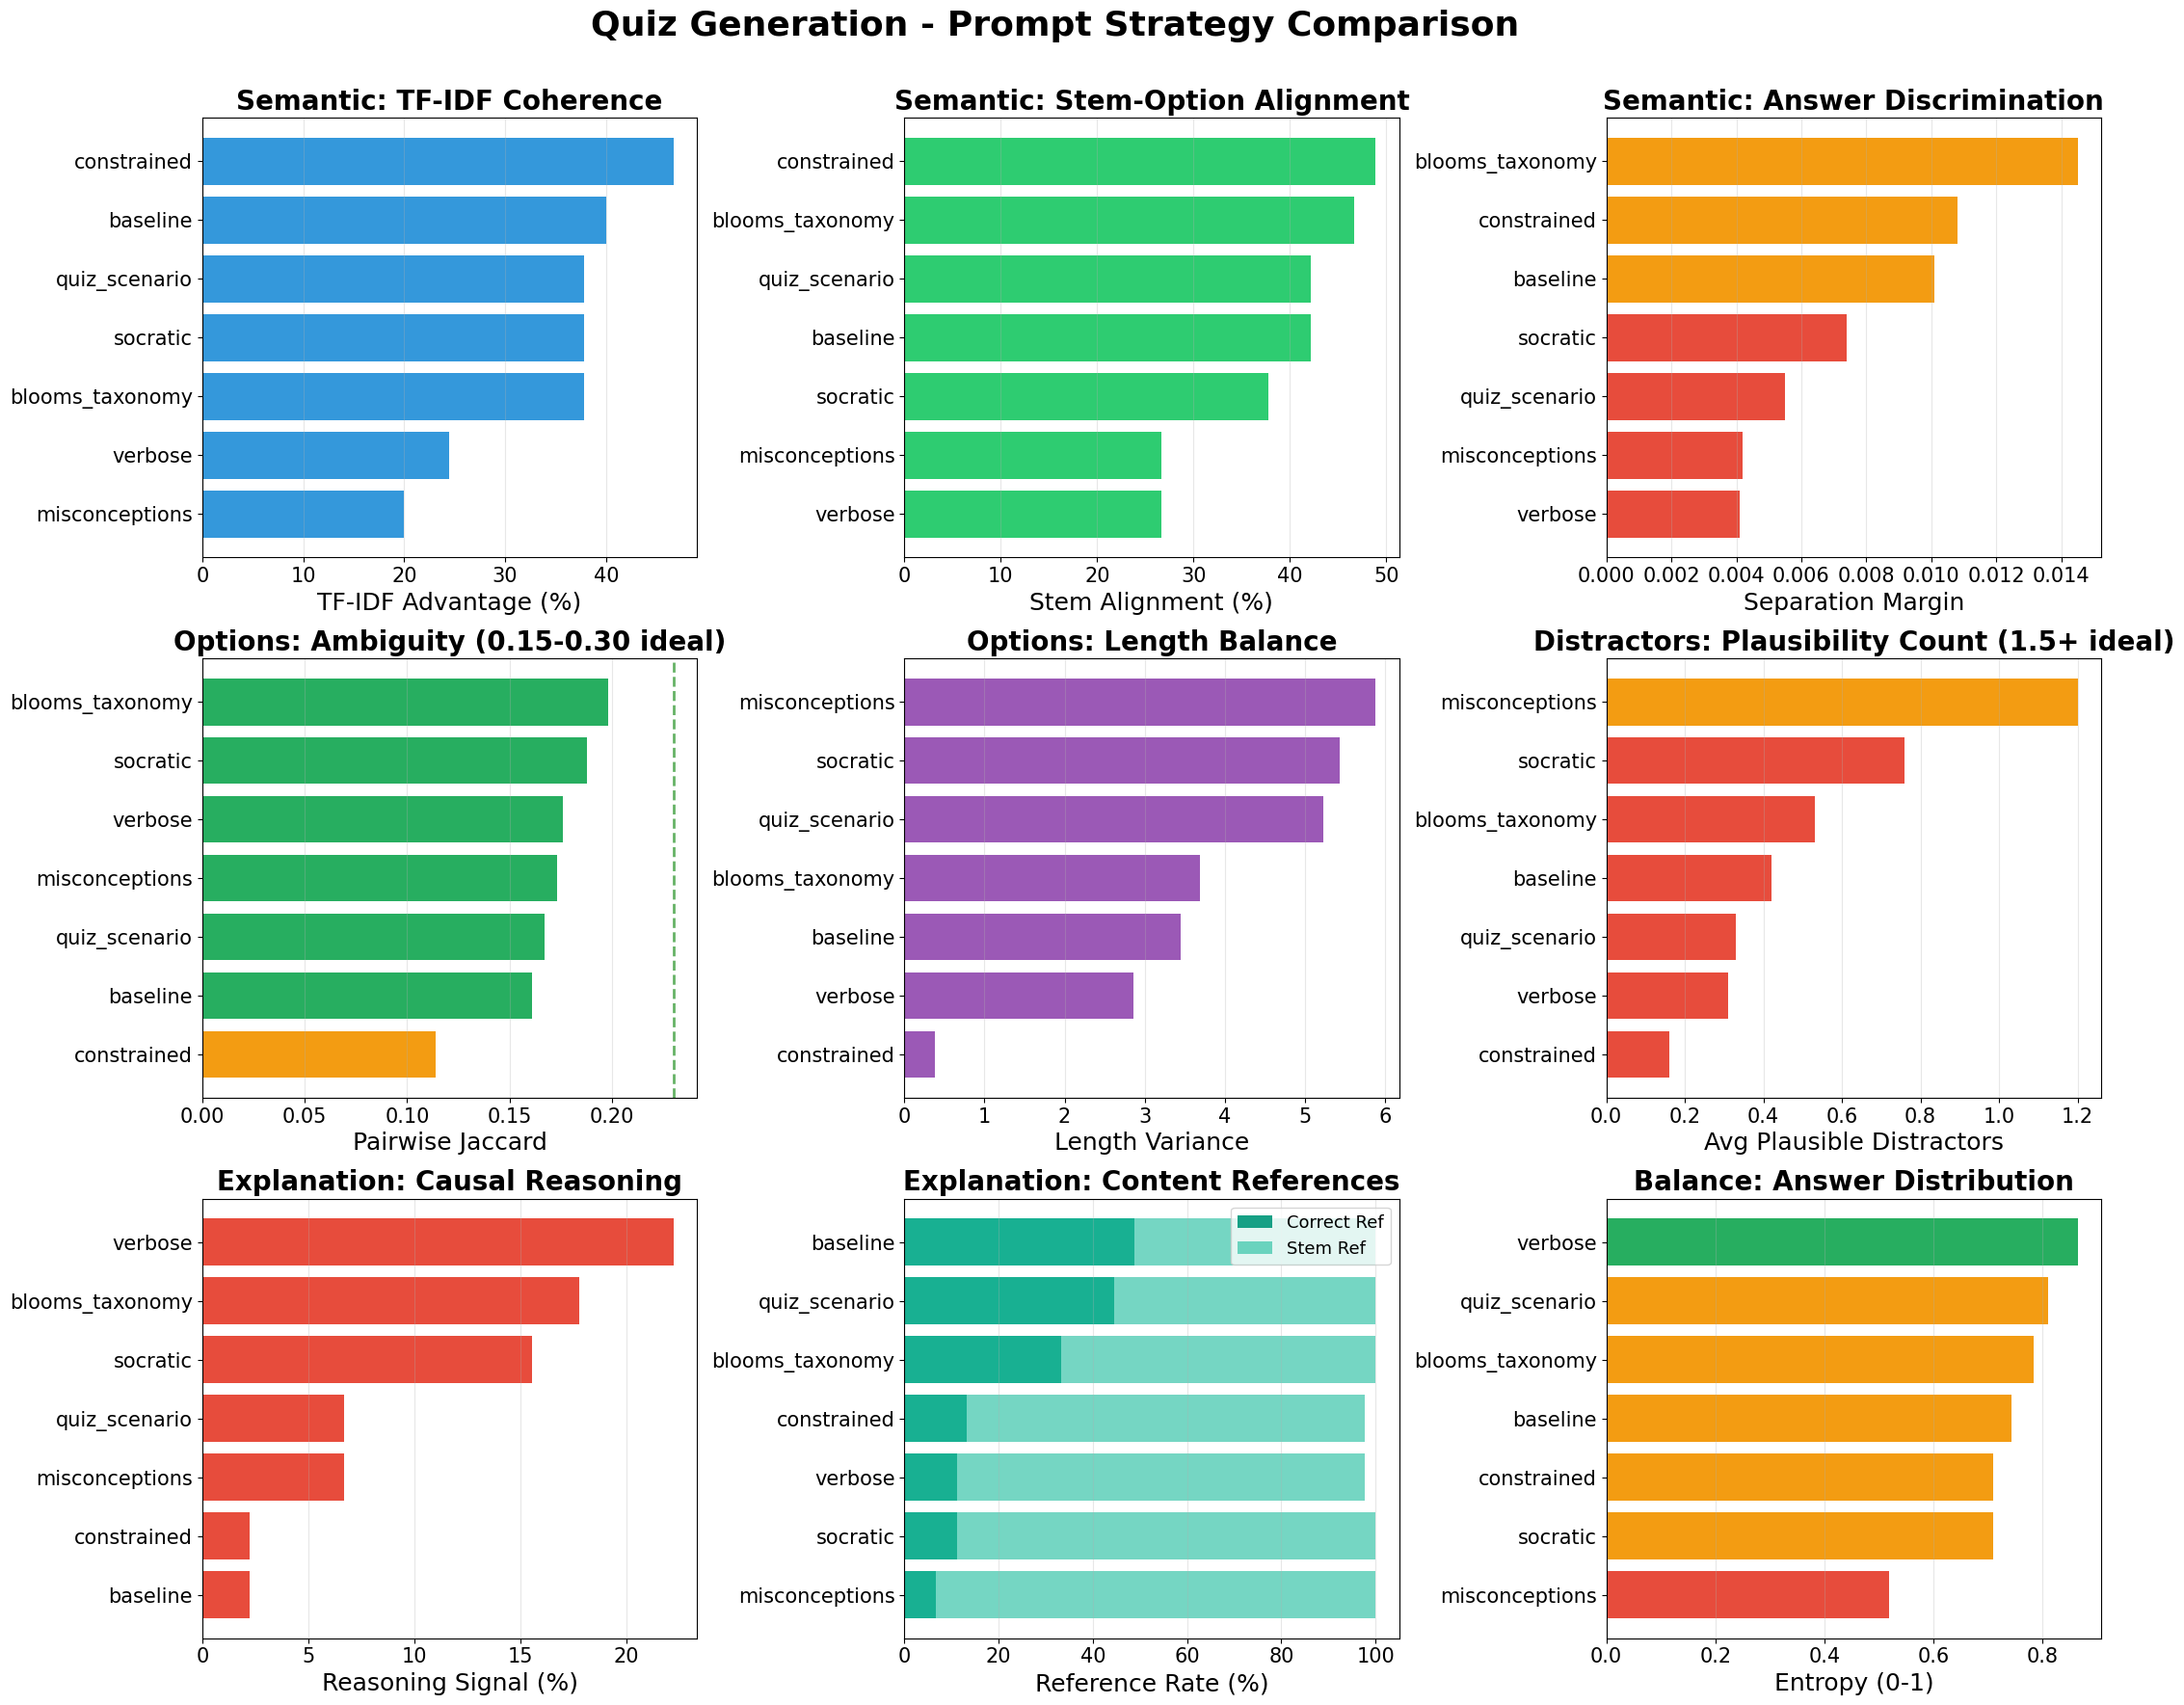


QUIZ QUALITY SUMMARY STATISTICS:
Best Semantic Coherence: socratic (46.7%)
Best Answer Discrimination: baseline (0.015)
Best Reasoning Quality: verbose (22.2%)
Best Question Balance: verbose (0.864)


In [51]:
plot_quiz_results(quiz_df, "Quiz Generation - Prompt Strategy Comparison")

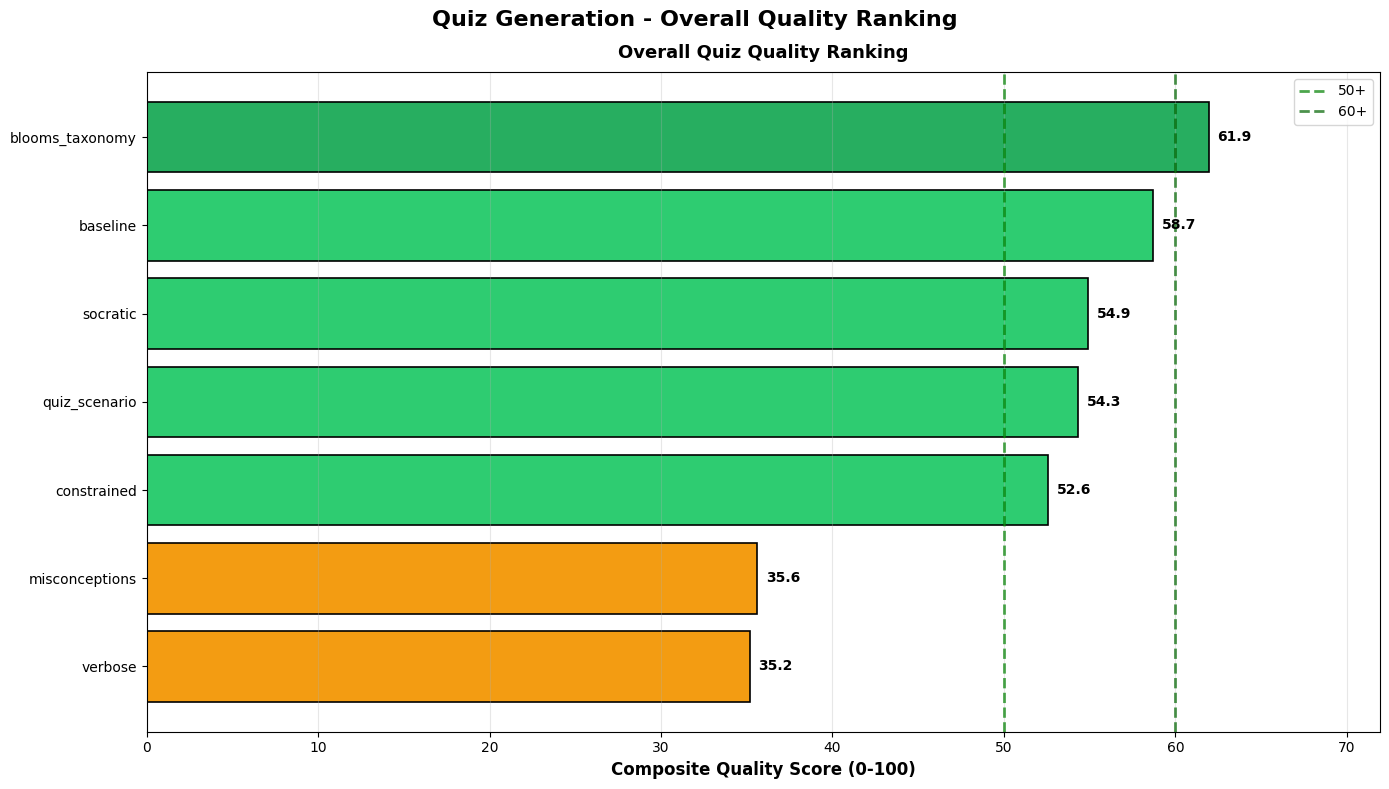


TOP 3 BREAKDOWN:

1. blooms_taxonomy - Overall Score: 61.93/100
   Semantic (28%): TF-IDF 37.8%, Stem Align 46.7%
   Discrimination (24%): Separation 0.015
   Distractors (20%): Plausible 0.53, Jacc 0.198, LenVar 3.68
   Explanation (15%): Reasoning 17.8%, Refs 33.3%
   Balance (10%): Entropy 0.783
   Quality (3%): Duplicates 0.0%

2. baseline - Overall Score: 58.72/100
   Semantic (28%): TF-IDF 40.0%, Stem Align 42.2%
   Discrimination (24%): Separation 0.010
   Distractors (20%): Plausible 0.42, Jacc 0.161, LenVar 3.45
   Explanation (15%): Reasoning 2.2%, Refs 48.9%
   Balance (10%): Entropy 0.743
   Quality (3%): Duplicates 0.0%

3. socratic - Overall Score: 54.89/100
   Semantic (28%): TF-IDF 37.8%, Stem Align 37.8%
   Discrimination (24%): Separation 0.007
   Distractors (20%): Plausible 0.76, Jacc 0.188, LenVar 5.43
   Explanation (15%): Reasoning 15.6%, Refs 11.1%
   Balance (10%): Entropy 0.710
   Quality (3%): Duplicates 0.0%


In [52]:
plot_composite_score(quiz_df, "Quiz Generation - Overall Quality Ranking")

# RESULTS ANALYSIS & INTERPRETATION

## Quality Scoring Methodology

The **Composite Quality Score (0-100)** aggregates multiple dimensions:
- **Semantic Coherence (30%)**: TF-IDF similarity + stem-option alignment
- **Answer Discrimination (25%)**: Separation margin between correct answer and best distractor
- **Distractor Quality (20%)**: Plausibility band + option ambiguity
- **Explanation Quality (15%)**: Reasoning signal + content references
- **Statistical Balance (10%)**: Answer distribution entropy

Higher scores indicate better pedagogical quality and quiz fairness.

C:\Users\anost\AppData\Local\Temp\ipykernel_27360\2352992872.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(angles, values, 'o-', linewidth=2, label=f"{rank_labels[idx]}: {row['Config']}",


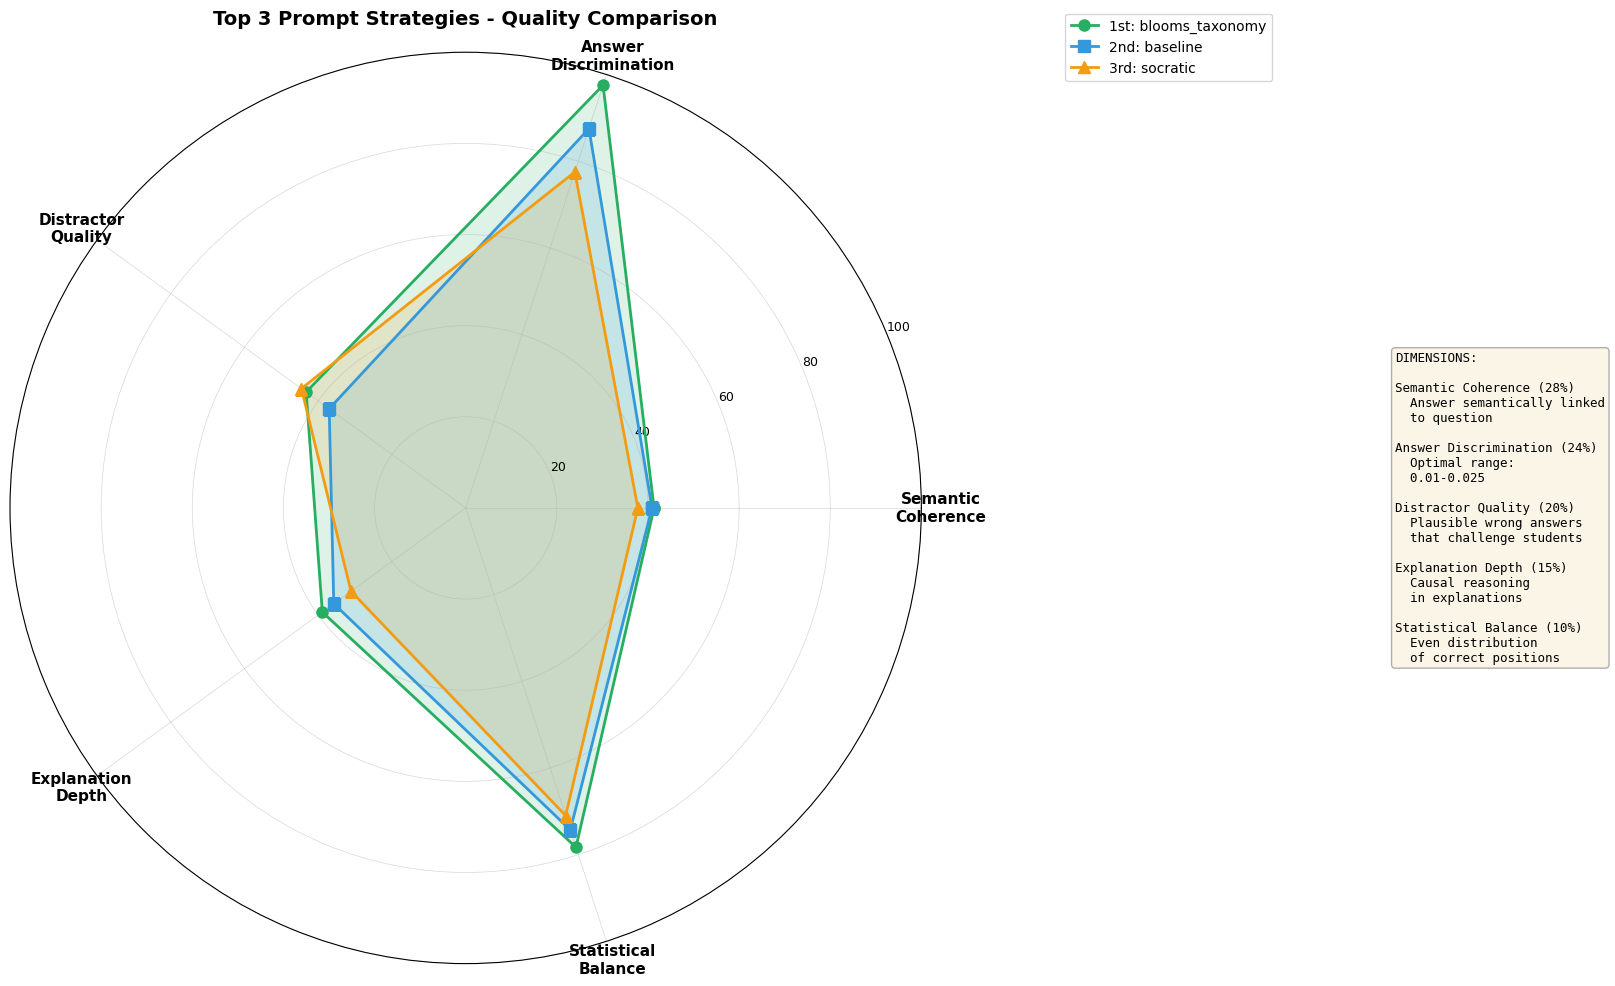

In [ ]:
def compare_top_prompts_radar(df, top_n=3):
    """Create radar chart comparing top N prompts across quality dimensions"""
    import numpy as np
    
    top_df = df.head(top_n)
    
    # Normalize key metrics to 0-100 scale for radar chart
    categories = ['Semantic\nCoherence', 'Answer\nDiscrimination', 'Distractor\nQuality', 
                  'Explanation\nDepth', 'Statistical\nBalance']
    
    fig, ax = plt.subplots(figsize=(16, 10), subplot_kw=dict(projection='polar'))
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    colors = ['#27ae60', '#3498db', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c', '#34495e', '#e67e22', '#95a5a6']
    markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'x']
    rank_labels = ["1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th"]
    
    for idx, (_, row) in enumerate(top_df.iterrows()):
        semantic = (row['TF-IDF Advantage (%)'] * 0.6 + row['Stem-Option Alignment OK (%)'] * 0.4)
        
        margin = row['Avg Separation Margin']
        optimal_margin = 0.018
        if margin < 0.005:
            discrimination = margin * 4000
        elif margin <= 0.025:
            distance_from_optimal = abs(margin - optimal_margin)
            penalty = (distance_from_optimal / 0.010) ** 2 * 20
            discrimination = 100 - penalty
        else:
            excess = margin - 0.025
            discrimination = max(60, 95 - excess * 1000)

        avg_plausible = row['Avg Plausible Distractors (0-3)']
        if avg_plausible >= 1.5:
            plausibility_score = min(100, avg_plausible * 40)
        else:
            plausibility_score = avg_plausible * 50
        
        option_jacc = row['Avg Option Pairwise Jaccard']
        if 0.15 <= option_jacc <= 0.30:
            option_ambiguity_score = 100 - abs(option_jacc - 0.225) * 400
        else:
            option_ambiguity_score = max(0, 100 - abs(option_jacc - 0.225) * 600)
        
        length_var = row['Avg Option Length Variance']
        if length_var <= 1.0:
            length_balance_score = 100
        elif length_var <= 2.5:
            length_balance_score = 100 - (length_var - 1.0) * 40
        else:
            length_balance_score = max(0, 40 - (length_var - 2.5) * 20)
        
        distractor_quality = (plausibility_score * 0.50 + 
                             option_ambiguity_score * 0.30 + 
                             length_balance_score * 0.20)
        
        explanation = (row['Reasoning Signal (%)'] * 0.5 + 
                      row['Explanation Correct Ref (%)'] * 0.3 + 
                      row['Explanation Stem Ref (%)'] * 0.2)

        entropy = row['Answer Entropy (0-1)']
        optimal_entropy = 0.95
        if entropy >= 0.85:
            distance = abs(entropy - optimal_entropy)
            penalty = (distance / 0.10) ** 2 * 15
            balance = 100 - penalty
        else:
            balance = entropy * 100
        
        values = [semantic, discrimination, distractor_quality, explanation, balance]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=f"{rank_labels[idx]}: {row['Config']}", 
                color=colors[idx], marker=markers[idx], markersize=8)
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=11, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'], size=9)
    ax.grid(True, linewidth=0.5, alpha=0.5)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1.05), fontsize=10)
    plt.title(f"Top {top_n} Prompt Strategies - Quality Comparison", 
              size=14, fontweight='bold', pad=20)
    
    # Add explanatory text box
    explanation_text = (
        "DIMENSIONS:\n\n"
        "Semantic Coherence (28%)\n"
        "  Answer semantically linked\n"
        "  to question\n\n"
        "Answer Discrimination (24%)\n"
        "  Optimal range:\n"
        "  0.01-0.025\n\n"
        "Distractor Quality (20%)\n"
        "  Plausible wrong answers\n"
        "  that challenge students\n\n"
        "Explanation Depth (15%)\n"
        "  Causal reasoning\n"
        "  in explanations\n\n"
        "Statistical Balance (10%)\n"
        "  Even distribution\n"
        "  of correct positions"
    )
    
    plt.text(1.52, 0.5, explanation_text, transform=ax.transAxes,
             fontsize=9, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
             family='monospace')
    
    plt.tight_layout()
    plt.show()

compare_top_prompts_radar(quiz_df, top_n=3)    

- **RAG Grounding** (uziemienie w źródle, overlap z kontekstem)
- **Coverage** (pokrycie materiału, entropia rozkładu chunków, różnorodność pojęć

In [ ]:

import numpy as np
import os

def evaluate_quiz_metrics(json_folder):
    all_results = []

    files = [f for f in os.listdir(json_folder) if f.endswith('.json')]
    
    for filename in files:
        path = os.path.join(json_folder, filename)
        with open(path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                continue
        
        for entry in data:
            quiz = entry.get('quiz_data', {})
            questions = quiz.get('questions', [])
            if not questions: continue
            
            q_metrics = []
            used_chunks = set()
            all_q_words = []
            
            for q in questions:
                q_text = q['question']
                explanation = q.get('explanation', "")
                source_data = q.get('source', {})
                chunk_text = source_data.get('chunkText', "")
                used_chunks.add(source_data.get('chunkId'))

                q_tokens = tokenize(q_text)
                exp_tokens = tokenize(explanation)
                chunk_tokens = tokenize(chunk_text)
                
                # Source Grounding (Alignment)
                grounding_score = jaccard(q_tokens, chunk_tokens)
                
                # Reference Density
                ref_density = jaccard(exp_tokens, chunk_tokens)
                
                q_metrics.append({
                    "grounding": grounding_score,
                    "ref_density": ref_density
                })
                all_q_words.extend(list(q_tokens))

            # Question Diversity
            unique_words = len(set(all_q_words))
            diversity = unique_words / len(all_q_words) if all_q_words else 0
            
            # Material Coverage
            coverage = len(used_chunks) / len(questions)

            all_results.append({
                "config": entry['config_label'],
                "test_type": entry['test_type'],
                "avg_grounding_score": np.mean([m['grounding'] for m in q_metrics]),
                "avg_reference_density": np.mean([m['ref_density'] for m in q_metrics]),
                "material_coverage": coverage,
                "vocabulary_diversity": diversity,
                "latency": entry['latency']
            })
            
    return pd.DataFrame(all_results)

df_final = evaluate_quiz_metrics('statistics//prompts')

print(df_final)

                                avg_grounding_score  avg_reference_density  \
config                                                                       
quiz_prompt_quiz_scenario                  0.102910               0.164096   
quiz_prompt_quiz_misconception             0.102258               0.168573   
quiz_prompt_constrained                    0.099652               0.166276   
quiz_prompt_blooms_taxonomy                0.091400               0.131705   
quiz_prompt_socratic                       0.091362               0.117516   
quiz_prompt_baseline                       0.087113               0.133271   
quiz_prompt_verbose                        0.081480               0.157588   

                                material_coverage  vocabulary_diversity  \
config                                                                    
quiz_prompt_quiz_scenario                     0.7              0.563636   
quiz_prompt_quiz_misconception                0.6              0.492424 

In [ ]:
import json
import pandas as pd

def evaluate_quiz_metrics(results_dir, chunks_paths):
    chunk_sets = {}
    for key, path in chunks_paths.items():
        if os.path.exists(path):
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                chunk_sets[key] = set(map(int, data.keys()))
    
    all_results = []
    files = [f for f in os.listdir(results_dir) if f.startswith('quiz_results_') and f.endswith('.json')]
    
    for filename in files:
        file_path = os.path.join(results_dir, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
            except:
                continue

        if isinstance(data, dict):
            data = [data]
            
        for entry in data:
            if not isinstance(entry, dict) or entry.get("error"):
                continue
                
            config = entry.get('config_label', filename)
            test_type = entry.get('test_type', 'full_course')
            quiz_data = entry.get('quiz_data', {})
            questions = quiz_data.get('questions', [])

            used_chunk_ids = set()
            for q in questions:
                cid = q.get('source', {}).get('chunkId')
                if cid is not None:
                    try:
                        used_chunk_ids.add(int(cid))
                    except (ValueError, TypeError):
                        continue
  
            target_key = None
            if test_type == 'full_course':
                target_key = 'general'
            elif test_type == 'materials_5_6':
                target_key = 'materials_5_6'
            elif test_type == 'topic':
                target_key = 'decision_trees'
            
            coverage_pct = 0.0
            if target_key in chunk_sets:
                relevant_chunks = chunk_sets[target_key]
                covered_in_this_scope = used_chunk_ids.intersection(relevant_chunks)
                total_relevant = len(relevant_chunks)
                
                if total_relevant > 0:
                    coverage_pct = (len(covered_in_this_scope) / total_relevant) * 100
            
            all_results.append({
                "config": config,
                "test_type": test_type,
                "material_coverage_pct": round(coverage_pct, 2),
                "num_questions": len(questions),
                "unique_chunks_used": len(used_chunk_ids),
                "latency": entry.get('latency', 0)
            })
            
    return pd.DataFrame(all_results)

paths = {
    'general': 'chunks_course11.json',
    'materials_5_6': 'chunks_materials5_6.json',
    'decision_trees': 'chunks_decision_trees.json'
}

df_metrics = evaluate_quiz_metrics('./prompts_quizzes', paths)

if not df_metrics.empty:
    summary = df_metrics.groupby(['config', 'test_type'])['material_coverage_pct'].mean().unstack()
    print(summary)
    df_metrics.to_csv('quiz_coverage_final_results.csv', index=False)

Wczytano 783 chunków dla zakresu: general
Wczytano 125 chunków dla zakresu: materials_5_6
Wczytano 167 chunków dla zakresu: decision_trees
test_type                       full_course  materials_5_6  topic
config                                                           
quiz_prompt_baseline                   0.89            8.8   3.59
quiz_prompt_blooms_taxonomy            1.40            6.4   2.99
quiz_prompt_constrained                0.64            9.6   4.19
quiz_prompt_quiz_misconception         1.02            NaN    NaN
quiz_prompt_quiz_scenario              1.15            4.8   3.59
quiz_prompt_socratic                   1.15            8.0   4.19
quiz_prompt_verbose                    1.28            8.0   2.99
